# $\psi_{10}$, $\psi_{21}$

<IPython.core.display.Javascript object>


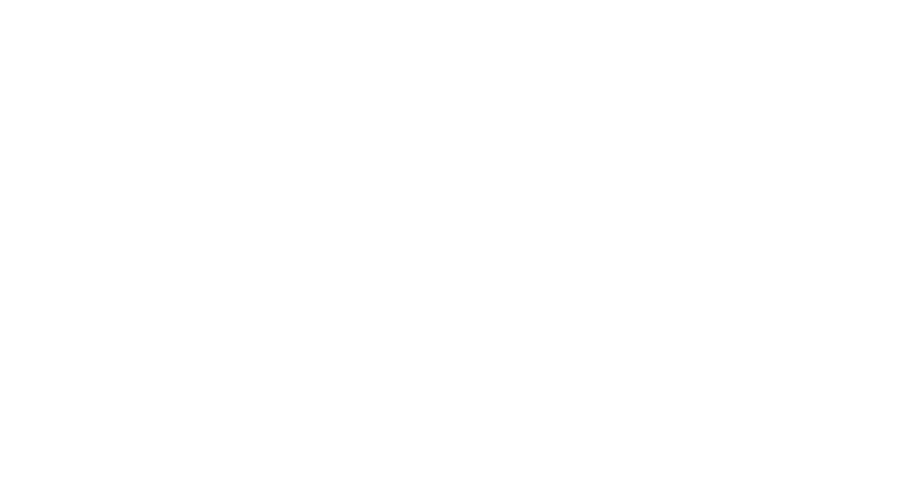

Training the NQS...: 100%|███████████████████████████████████████████████████████| 3000/3000 [00:03<00:00, 801.02it/s]


<IPython.core.display.Javascript object>


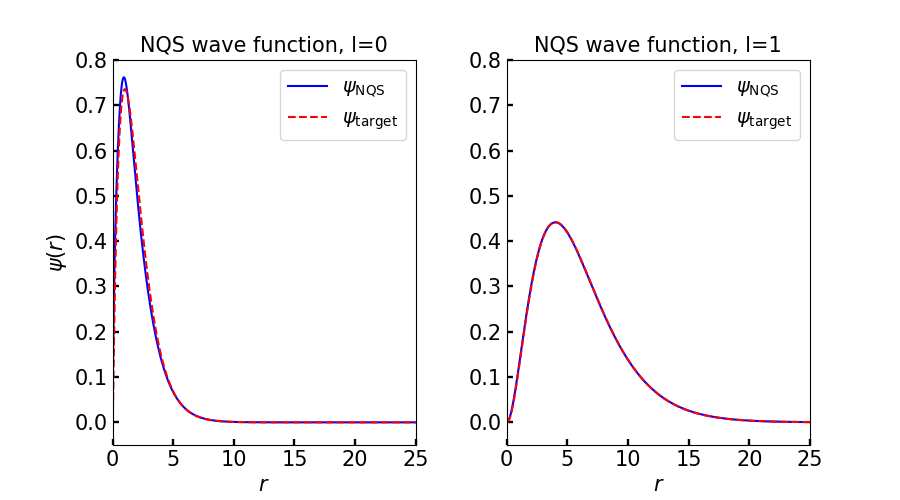

Training the NQS...: 100%|███████████████████████████████████████████████████████| 3000/3000 [00:05<00:00, 521.13it/s]


In [1]:
# Imports
import torch, time
from torch import nn, Tensor
from torch.autograd import grad
import numpy as np
import matplotlib.pyplot as plt # Plotting library
from tqdm import tqdm # Progress bar

Z = 1 # atomic number
psi_l1 = []
psi_l2 = []
P_10 = lambda r : 2.*np.power(Z, 1.5)*r*np.exp(-Z*r)
P_21 = lambda r : (1/(2*np.sqrt(6.)))*np.power(Z, 2.5)*np.power(r, 2)*np.exp(-Z*r/2.)
r_grid = np.linspace(0, 25, 1000)
target_l1 = P_10(r_grid)
target_l2 = P_21(r_grid)

for l in [0, 1]:
    # Hardware (CPU or GPU)
    dev = 'cuda' if torch.cuda.is_available() else 'cpu'
    device = torch.device(dev)

    # Network hyperparameters
    Nin = 1   # Inputs to the neural network
    Nout = 1  # Outputs of the neural network
    Nhid = 8  # Nodes in the hidden layer

    # Physical parameters
    Z = 1 # atomic number

    # Network parameters.
    seed = 2
    torch.manual_seed(seed)
    W1 = torch.rand(Nhid, Nin, requires_grad=True) * (-1.) # First set of coefficients
    B = torch.rand(Nhid, requires_grad=True) * 2. - 1.    # Set of bias parameters
    W2 = torch.rand(Nout, Nhid, requires_grad=True)        # Second set of coefficients

    # Training hyperparameters
    epochs = 3000
    lr = 1e-3  # Learning rate

    # Mesh parameters
    Nr = 1000                    # Mesh division
    train_a = 0                     # Mesh lower limit
    train_b = 25                        # Mesh upper limit
    h = (train_b - train_a) / (Nr - 1)  # Mesh parameter "h"
    wi = torch.empty(Nr, 1).fill_(h) # Integration weights. Trapezoids with zero boundaries
    Q_train = torch.linspace(train_a+h, train_b, Nr, requires_grad=True, device=device)  

    class HarmonicNQS(nn.Module):
        def __init__(self, W1, B, W2):
            super(HarmonicNQS, self).__init__()

            # We set the operators 
            self.lc1 = nn.Linear(in_features=Nin, 
                                 out_features=Nhid, 
                                 bias=True)   # shape = (Nhid, Nin)
            self.actfun = nn.Sigmoid()        # activation function
            self.lc2 = nn.Linear(in_features=Nhid, 
                                 out_features=Nout, 
                                 bias=False)  # shape = (Nout, Nhid)

            # We set the parameters 
            with torch.no_grad():
                self.lc1.weight = nn.Parameter(W1)
                self.lc1.bias = nn.Parameter(B)
                self.lc2.weight = nn.Parameter(W2)

        # We set the architecture
        def forward(self, x): 
            o = self.lc2(self.actfun(self.lc1(x)))
            return o
    
    net = HarmonicNQS(W1, B, W2).to(device)
    optimizer = torch.optim.RMSprop(params=net.parameters(), lr=lr)
    
    def loss_fn():  
        X_det = X.clone().detach()
        psi = net(X)*X.pow(l+1)
        psi2 = (net(X_det)*X_det.pow(l+1)).pow(2)
        dpsi_dr, = grad(outputs=psi, 
                        inputs=X,
                        grad_outputs=torch.ones_like(psi), 
                        create_graph=True)   
        N = torch.tensordot(psi2, wi)                 
        U = torch.tensordot(psi2 * ( l*(l+1)/(2*X_det.pow(2)) - Z/X_det ), wi) / N  
        K = (1/2) * torch.tensordot(dpsi_dr.pow(2), wi) / N

        return K + U, U, K, psi, psi / torch.sqrt(N)
    
    def pic(i, x, psi_l1, psi_l2, target_l1, target_l2, ax1, ax3):  
        
        # First l
        ax1.set_title('NQS wave function, l=0', fontsize=15)
        wf = psi_l1.detach().numpy()
        maxwf = np.max(wf)
        if maxwf < 0: wf = -wf
        if ax1.lines:
            # This will run every time the function is called except the first one
            ax1.lines[0].set_xdata(x.detach().numpy())
            ax1.lines[0].set_ydata(wf)
            ax1.lines[1].set_xdata(x.detach().numpy())
            ax1.lines[1].set_ydata(target_l1)
        else:
            # This code will only run the first time the function is called
            ax1.plot(x.detach().numpy(), wf, label='$\psi_\mathrm{NQS}$', color='b')
            ax1.plot(x.detach().numpy(), target_l1, linestyle="--", 
                     label='$\psi_\mathrm{target}$', color='r')
            ax1.legend(loc='upper right', fontsize=14)

        # Second l
        ax3.set_title('NQS wave function, l=1', fontsize=15)
        wf = psi_l2.detach().numpy()
        maxwf = np.max(wf)
        if maxwf < 0: wf = -wf
        if ax3.lines:
            # This will run every time the function is called except the first one
            ax3.lines[0].set_xdata(x.detach().numpy())
            ax3.lines[0].set_ydata(wf)
            ax3.lines[1].set_xdata(x.detach().numpy())
            ax3.lines[1].set_ydata(target_l2)
        else:
            # This code will only run the first time the function is called
            ax3.plot(x.detach().numpy(), wf, label='$\psi_\mathrm{NQS}$', color='b')
            ax3.plot(x.detach().numpy(), target_l2, linestyle="--", 
                     label='$\psi_\mathrm{target}$', color='r')
            ax3.legend(loc='upper right', fontsize=14)

        fig.canvas.draw()

    X = Q_train.clone().unsqueeze(1)
    r_grid = Q_train.clone().detach().numpy()
    r_grid = np.linspace(train_a, train_b, 10000)
    
    %matplotlib notebook
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 5))
    ax1, ax3 = ax[0], ax[1]
    plt.subplots_adjust(wspace=0.3)

    # Overlap
    ax1.set_xlim(0, 25)
    ax1.set_ylim(-0.05, 0.8)
    ax1.set_xlabel("$r$", fontsize=15)
    ax1.set_ylabel("$\psi(r)$", fontsize=15)
    ax1.set_xticks(np.arange(0, 25.01, step=5))
    ax1.tick_params(axis='both', labelsize=15)
    ax1.tick_params(axis='both', which='both', direction='in')
    ax1.tick_params(axis='both', which='major', width=1.7, length=4.5)

    # Loss
    ax3.set_xlabel("$r$", fontsize=15)
    ax3.set_xticks(np.arange(0, 25.01, step=5))
    ax3.tick_params(axis='both', labelsize=15)
    ax3.tick_params(axis='both', which='both', direction='in')
    ax3.tick_params(axis='both', which='major', width=1.7, length=4.5)
    ax3.set_xlim(0, 25)
    ax3.set_ylim(-0.05, 0.8)

    loss_accum = []
    U_accum = []
    K_accum = []
    
    # Training
    for i in tqdm(range(epochs), desc="Training the NQS..."):
        loss0, U, K, psi, psi_normalized = loss_fn()    # Energy and \psi calculation

        optimizer.zero_grad() # initialize gradients to zero at each epoch
        loss0.backward()       # computation of the gradients
        optimizer.step()      # update of the parameters

        loss_accum.append(loss0.item())
        U_accum.append(U.item())
        K_accum.append(K.item())

        if (i == epochs - 1) or (i % 500 == 0): # We plot periodically
            if l == 0:
                psi_l1 = psi_normalized.clone().detach()
                E_10, psi_10 = loss_accum[-1], psi.clone().detach()
            elif l == 1:
                psi_l2 = psi_normalized.clone().detach()
                pic(i, Q_train, psi_l1, psi_l2, target_l1, target_l2, ax1, ax3)
                time.sleep(0.01)
                plt.savefig('H_training.pdf', format='pdf', bbox_inches='tight')

# $\psi_{20}$

<IPython.core.display.Javascript object>


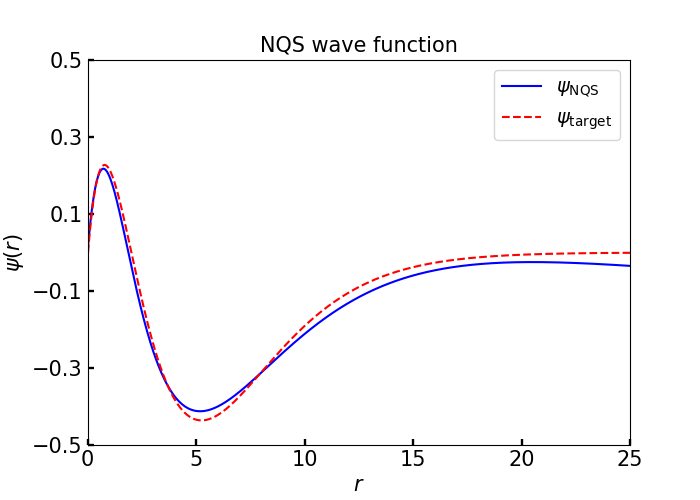

Training the NQS...: 100%|███████████████████████████████████████████████████████| 3000/3000 [00:06<00:00, 482.12it/s]


In [3]:
def loss_fn_prime(l):  
    X_det = X.clone().detach()
    # Energy term
    psi = net1(X)*X.pow(l+1)
    psi2 = (net1(X_det)*X_det.pow(l+1)).pow(2)
    dpsi_dr, = grad(outputs=psi, 
                    inputs=X,
                    grad_outputs=torch.ones_like(psi), 
                    create_graph=True)   
    N = torch.tensordot(psi2, wi)                 
    U = torch.tensordot(psi2 * ( l*(l+1)/(2*X_det.pow(2)) - Z/X_det ), wi) / N  
    K = (1/2) * torch.tensordot(dpsi_dr.pow(2), wi) / N
    E = K + U
    
    # Overlap term
    num = (torch.tensordot(psi*psi_10, wi)).pow(2)
    den = (torch.tensordot(psi2, wi)) * (torch.tensordot(psi_10.pow(2), wi))
    O = lambda_ * (num / den)
    
    # Total loss
    L = E + O
    
    return L, U, K, psi, psi / torch.sqrt(N) 

# Network hyperparameters
Nin = 1   # Inputs to the neural network
Nout = 1  # Outputs of the neural network
Nhid = 20  # Nodes in the hidden layer

l = 0

# Network parameters.
seed = 1
torch.manual_seed(seed)
W1 = torch.rand(Nhid, Nin, requires_grad=True) * (-1.) # First set of coefficients
B = torch.rand(Nhid, requires_grad=True) * 2. - 1.    # Set of bias parameters
W2 = torch.rand(Nout, Nhid, requires_grad=True)        # Second set of coefficients
lr = 5e-3
lambda_ = 10.

net1 = HarmonicNQS(W1, B, W2).to(device)
optimizer = torch.optim.RMSprop(params=net1.parameters(), lr=lr)
epochs = 3000

def pic(i, x, psi, target, ax1):  
        
    # First l
    ax1.set_title('NQS wave function', fontsize=15)
    wf = psi.detach().numpy()
    maxwf = np.max(wf)
    wf *= -1.
    if ax1.lines:
        # This will run every time the function is called except the first one
        ax1.lines[0].set_xdata(x.detach().numpy())
        ax1.lines[0].set_ydata(wf)
        ax1.lines[1].set_xdata(x.detach().numpy())
        ax1.lines[1].set_ydata(target)
    else:
        # This code will only run the first time the function is called
        ax1.plot(x.detach().numpy(), wf, label='$\psi_\mathrm{NQS}$', color='b')
        ax1.plot(x.detach().numpy(), target, linestyle="--", 
                 label='$\psi_\mathrm{target}$', color='r')
        ax1.legend(loc='upper right', fontsize=14)

    fig.canvas.draw()

X = Q_train.clone().unsqueeze(1)
r_grid = np.linspace(train_a, train_b, 1000)
P_20 = lambda r : (1/np.sqrt(2.))*np.power(Z, 1.5)*r*(1-0.5*Z*r)*np.exp(-Z*r/2.)
target = P_20(r_grid)

%matplotlib notebook
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))

# Overlap
ax.set_xlim(0, 25)
ax.set_ylim(-0.501, 0.501)
ax.set_xlabel("$r$", fontsize=15)
ax.set_ylabel("$\psi(r)$", fontsize=15)
ax.set_xticks(np.arange(0, 25.01, step=5))
ax.set_yticks(np.arange(-0.5, 0.51, step=0.2))
ax.tick_params(axis='both', labelsize=15)
ax.tick_params(axis='both', which='both', direction='in')
ax.tick_params(axis='both', which='major', width=1.7, length=4.5)

loss_accum = []
U_accum = []
K_accum = []

# Training
for i in tqdm(range(epochs), desc="Training the NQS..."):
    loss0, U, K, psi, psi_normalized = loss_fn_prime(l)    # Energy and \psi calculation

    optimizer.zero_grad() # initialize gradients to zero at each epoch
    loss0.backward()       # computation of the gradients
    optimizer.step()      # update of the parameters

    loss_accum.append(loss0.item())
    U_accum.append(U.item())
    K_accum.append(K.item())

    if (i == epochs - 1) or (i % 500 == 0): # We plot periodically
        psi = psi_normalized.clone().detach()
        pic(i, Q_train, psi, target, ax)
        time.sleep(0.01)
        plt.savefig('H_training_excited.pdf', format='pdf', bbox_inches='tight')